In [8]:
import os
import sys

module_path = os.path.abspath(os.path.join("src"))
sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns

from src.experiment import run_experiment
from src.data import transform_cnn, transform_flat

sns.set_theme()


## Plotting Functions
We will use this functions for displaying results of trainings

In [9]:
def plot_partitions(data, full_acc, title):
    """Plotting results for different partitions assuming only one training per partition."""
    df = data.stack()
    df = df.reset_index().rename(
        columns={"level_0": "Partitions", "level_1": "Type", 0: "Accuracy"}
    )
    df.loc[df["Type"] != "aggregated", "Type"] = "local model"

    g = sns.barplot(data=df, x="Partitions", y="Accuracy", hue="Type")

    red = sns.color_palette()[3]
    g.axhline(y=full_acc, color=red, linestyle="--", label="centralized model")

    transform = transforms.blended_transform_factory(
        g.get_yticklabels()[0].get_transform(), g.transData
    )
    g.text(
        0,
        full_acc,
        f"{full_acc:.3f}",
        color=red,
        transform=transform,
        ha="right",
        va="center",
        fontsize=10,
    )

    g.set_title(title)
    g.legend().set_title("Model type")
    g.set_ylim((0, 1))
    plt.show()


def plot_lines(data, full_acc, title, y_lim=None):
    """Plotting function use to plot training accuracy over iterations."""
    df = pd.DataFrame(data)
    df = df.stack()
    df = df.reset_index().rename(
        columns={"level_0": "Iteration", "level_1": "Type", 0: "Accuracy"}
    )
    df["Iteration"] += 1
    df.loc[df["Type"] != "aggregated", "Type"] = "local model"

    g = sns.lineplot(data=df, x="Iteration", y="Accuracy", hue="Type")

    red = sns.color_palette()[3]
    g.axhline(y=full_acc, color=red, linestyle="--", label="centralized model")

    transform = transforms.blended_transform_factory(
        g.get_yticklabels()[0].get_transform(), g.transData
    )
    g.text(
        0,
        full_acc,
        f"{full_acc:.3f}",
        color=red,
        transform=transform,
        ha="right",
        va="center",
        fontsize=10,
    )

    g.set_title(title)
    g.legend().set_title("Model type")
    if y_lim is not None:
        g.set_ylim(y_lim)
    plt.show()

# Logistic Regression


In [ ]:
data = pd.DataFrame()

exp = {
    "iterations": 1,
    "full_iterations": 1,
    "partitions": 3,
    "data_transform": transform_flat,
    "model_definition": {
        "model_type": "sklearn",
        "model_name": "LogisticRegression",
        "init_params": {"max_iter": 100},
    },
}

for partitions in [3, 5, 10, 20, 50, 100]:
    exp["partitions"] = partitions
    train_acc1, full_acc1 = run_experiment(**exp)

    train_acc1 = pd.DataFrame(train_acc1)
    data.loc[partitions, train_acc1.columns] = train_acc1.iloc[0]


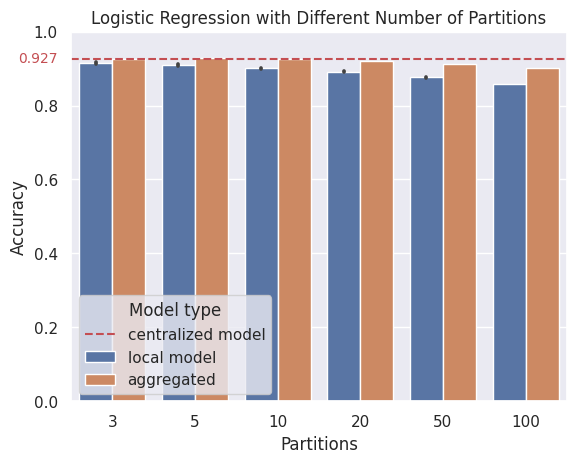

In [11]:
plot_partitions(data, full_acc1, "Logistic Regression with Different Number of Partitions")

# Centroid Classifier


In [ ]:
data = pd.DataFrame()

exp = {
    "iterations": 1,
    "full_iterations": 1,
    "partitions": 3,
    "data_transform": transform_flat,
    "model_definition": {
        "model_type": "sklearn",
        "model_name": "NearestCentroidClassifier",
        "init_params": {},
    },
}

for partitions in [3, 5, 10, 20, 50, 100]:
    exp["partitions"] = partitions
    train_acc1, full_acc1 = run_experiment(**exp)

    train_acc1 = pd.DataFrame(train_acc1)
    data.loc[partitions, train_acc1.columns] = train_acc1.iloc[0]


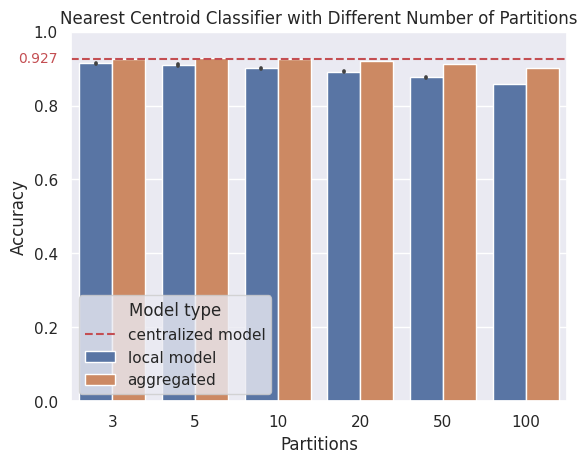

In [45]:
plot_partitions(data, full_acc1, "Nearest Centroid Classifier with Different Number of Partitions")

# MLP Classifier


In [ ]:
exp = {
    "iterations": 8,
    "full_iterations": 8,
    "partitions": 3,
    "data_transform": transform_flat,
    "model_definition": {
        "model_type": "sklearn",
        "model_name": "MLPClassifier",
        "init_params": {
            "hidden_layer_sizes": [50, 50],
            "max_iter": 50,
            "warm_start": True,
            "random_state": 10,
        },
    },
}

train_acc, full_acc = run_experiment(**exp)

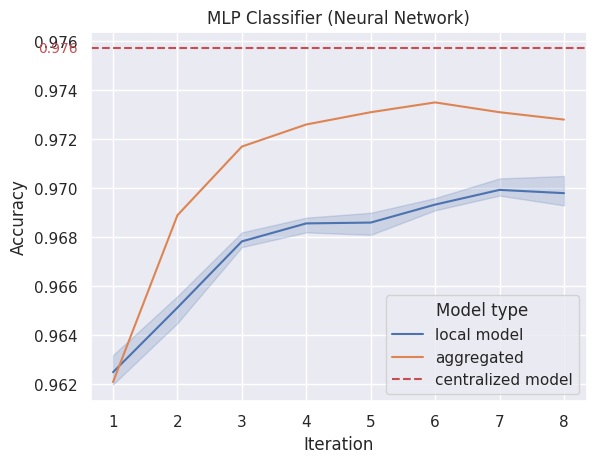

In [12]:
plot_lines(train_acc, full_acc, "MLP Classifier (Neural Network)")

# Custom CNN
Architecture (`architecture` in model definition) is comma-separated list of the following layers:
- `C-filters-kernel_size-stride-padding`: Add a convolutional layer with ReLU
    activation and specified number of filters, kernel size, stride and padding.  
    Example: `C-10-3-1-same`
- `CB-filters-kernel_size-stride-padding`: Same as `C`, but use batch normalization.
    In detail, start with a convolutional layer without bias and activation,
    then add batch normalization layer, and finally ReLU activation.  
    Example: `CB-10-3-1-same`
- `M-kernel_size-stride`: Add max pooling with specified size and stride.  
    Example: `M-3-2`
- `R-[layers]`: Add a residual connection. The `layers` contain a specification
    of at least one convolutional layer (but not a recursive residual connection `R`).
    The input to the specified layers is then added to their output
    (after the ReLU nonlinearity of the last one).  
    Example: `R-[C-16-3-1-same,C-16-3-1-same]`
- `F`: Flatten inputs. Must appear exactly once in the architecture.
- `H-hidden_layer_size`: Add a dense layer with ReLU activation and specified size.  
    Example: `H-100`
- `D-dropout_rate`: Apply dropout with the given dropout rate.  
    Example: `D-0.5`

_Training will fail if you provide invalid model definition._


In [ ]:
exp = {
    "iterations": 10,
    "full_iterations": 10,
    "partitions": 3,
    "data_transform": lambda data: data.reshape((len(data), 28, 28, 1)) / 255.5,
    "model_definition": {
        "model_type": "tensorflow",
        "model_name": "CustomCNN",
        "init_params": {
            "input_shape": [28, 28, 1],
            "classes": 10,
            "architecture": "C-20-3-2-same,M-3-2,F,H-100",
        },
        "fit_args": {"epochs": 1, "batch_size": 32},
    },
}

train_acc, full_acc = run_experiment(**exp)

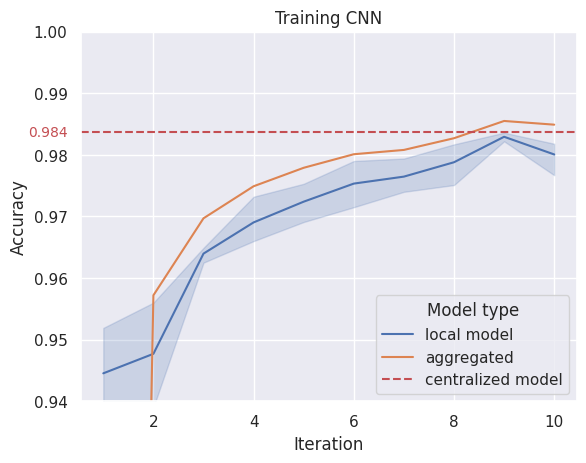

In [7]:
plot_lines(train_acc, full_acc, "Training CNN", (0.94, 1))

# Training Efficient Net B0


In [ ]:
exp = {
    "iterations": 6,
    "full_iterations": 6,
    "partitions": 3,
    "data_transform": transform_cnn,
    "model_definition": {
        "model_type": "tensorflow",
        "model_name": "EfficientNetB0",
        "init_params": {
            "input_shape": [32, 32, 3],
            "classes": 10,
            "include_top": True,
            "weights": None,
        },
        "fit_args": {"epochs": 1, "batch_size": 32},
    },
}

train_acc, full_acc = run_experiment(**exp)


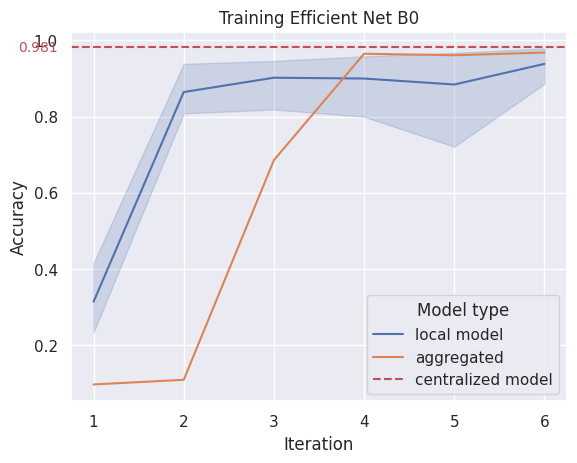

In [9]:
plot_lines(train_acc, full_acc, "Training Efficient Net B0")